<a href="https://colab.research.google.com/github/5ahar-K/Project/blob/main/Tracking%20various%20L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.special import kv, gamma
from scipy.integrate import cumulative_trapezoid
import math # Import the standard math module

# ----------------------------
# 1) h_ul = exp(-zeta1 * Z)
# ----------------------------
def sample_hul(Z, zeta1):
    return np.exp(-zeta1 * Z)

# ----------------------------
# 2) Málaga PDF f_hua(h)
#    Eq. (3) in the paper
#    NOTE: This form uses a finite sum m=1..beta, so beta should be an integer.
# ----------------------------
def malaga_pdf(h, alpha, beta, g, Omega):
    """
    Málaga(M) irradiance PDF from Eq. (3) in the PDF.
    Parameters:
      alpha, beta : large/small scale parameters (beta should be integer for this finite-sum form)
      g, Omega    : Málaga parameters (see paper's Table I context)
    """
    h = np.asarray(h)
    h = np.maximum(h, 1e-300)  # avoid 0 in power terms

    # A_M const(Eq 3, Comprehensive Paper)
    AM = (2 * (alpha**(alpha/2.0)) / (g**(1 + alpha/2.0) * gamma(alpha))) * \
         ((g*beta / (g*beta + Omega))**(beta + alpha/2.0))

    out = np.zeros_like(h, dtype=float)

    # finite sum m=1..beta (assumes beta is integer)
    beta_int = int(beta)
    if beta_int != beta:
        raise ValueError("This Málaga PDF implementation assumes beta is an integer (finite sum m=1..beta).")

    for m in range(1, beta_int + 1):
        # a_m (paper's Eq. (3) description)
        am = (math.comb(beta_int - 1, m - 1) * # Corrected: use math.comb
              (g*beta + Omega)**(1 - m/2.0) / math.factorial(m - 1) * # Corrected: use math.factorial
              (Omega / g)**(m - 1) *
              (alpha / beta)**(m/2.0))

        nu = alpha - m
        arg = 2.0 * np.sqrt(alpha * beta * h / (g*beta + Omega))

        out += am * (h**((alpha + m)/2.0 - 1.0)) * kv(nu, arg)

    return AM * out

# ----------------------------
# 3) Sample Málaga via numerical inverse-CDF
# ----------------------------
def sample_malaga(alpha, beta, g, Omega, size=1, h_max=50.0, grid_n=200000, rng=None):
    """
    Draw samples from Málaga(M) by building a numerical CDF on [0, h_max]
    and inverting it.

    Tips:
      - Increase h_max if you expect very heavy tails.
      - Increase grid_n for more accuracy (slower).
    """
    if rng is None:
        rng = np.random.default_rng()

    # Build grid
    h_grid = np.linspace(0.0, h_max, grid_n)
    # avoid h=0 exactly for stability in pdf
    h_grid[0] = 1e-12

    pdf = malaga_pdf(h_grid, alpha, beta, g, Omega)
    # Normalize numerically in case of truncation at h_max
    cdf = cumulative_trapezoid(pdf, h_grid, initial=0.0)
    cdf /= cdf[-1]  # normalize so last value is 1

    # Inverse-CDF sampling
    u = rng.random(size)
    samples = np.interp(u, cdf, h_grid)
    return samples

# ----------------------------
# 4) Sample h1 = h_ul * h_ua
# ----------------------------
def sample_h1(Z, zeta1, alpha, beta, g, Omega, size=1, rng=None,
              h_max=50.0, grid_n=200000):
    hul = sample_hul(Z, zeta1)  # scalar
    hua = sample_malaga(alpha, beta, g, Omega, size=size, rng=rng,
                        h_max=h_max, grid_n=grid_n)
    return hul * hua
def one_trial_outage(Pt, params, rng, gamma_th_dB=5.0):
    """
    Outage if:
      (a) AoA interruption (spot outside array), OR
      (b) instantaneous SNR < gamma_th
    """
    Na      = params["Na"]
    wa      = params["wa"]
    wf      = params["wf"]
    fc      = params["fc"]
    sigma_I = params["sigma_I"]
    sigma_x = params["sigma_x"]
    sigma_y = params["sigma_y"]
    mu      = params["mu"]
    sigma_s = params["sigma_s"]
    sigma0  = params["sigma0"]

    theta_x = rng.normal(0.0, sigma_x)
    theta_y = rng.normal(0.0, sigma_y)

    h2s, interrupted = h2_scalar_and_interrupt(
        theta_x, theta_y, Na, wa, wf, fc, sigma_I
    )
    if interrupted:
        return 1  # outage

    gamma_th = 10**(gamma_th_dB / 10.0)

    mean = mu * Pt * h2s
    var  = (sigma_s**2) * (Pt * h2s) + sigma0**2
    gamma = (mean**2) / var

    return int(gamma < gamma_th)

    # --- h1 draw (atmospheric attenuation + turbulence)
    Z     = h1_params["Z"]
    zeta1 = h1_params["zeta1"]
    alpha = h1_params["alpha"]
    beta  = h1_params["beta"]
    g     = h1_params["g"]
    Omega = h1_params["Omega"]
    h_max = h1_params.get("h_max", 100.0)
    grid_n= h1_params.get("grid_n", 300000)

    h1 = float(sample_h1(Z, zeta1, alpha, beta, g, Omega, size=1, rng=rng,
                         h_max=h_max, grid_n=grid_n)[0])

    # --- total gain
    h = h1 * h2s

    # --- instantaneous SNR for OOK '1' symbol
    mean = mu * Pt * h
    var  = (sigma_s**2) * (Pt * h) + sigma0**2
    gamma = (mean**2) / var

    return (gamma < gamma_th_lin)




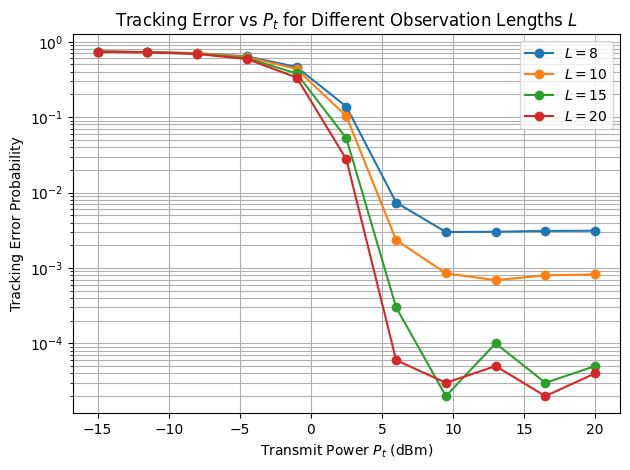

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# ======================
# Helper: Q-function
# ======================
def Q(x):
    return 0.5 * erfc(x / np.sqrt(2.0))

# ======================
# Vectorized h2 computation for MANY trials at once
# ======================
def compute_h2_batch(theta_x, theta_y, Na, wa, wf, fc, sigma_I):
    """
    theta_x, theta_y: (B,)
    returns h2: (B, Na, Na), normalized per trial
    """
    w_prime = wa + wf
    x0 = fc * theta_x  # (B,)
    y0 = fc * theta_y  # (B,)

    i = np.arange(Na)
    j = np.arange(Na)

    x_left  = (i - 1 - Na/2) * w_prime + wf/2
    x_right = (i     - Na/2) * w_prime - wf/2
    # broadcast: (B,Na)
    ax1 = (x_left[None, :]  - x0[:, None]) / sigma_I
    ax2 = (x_right[None, :] - x0[:, None]) / sigma_I
    px = Q(ax1) - Q(ax2)

    y_bottom = (j - 1 - Na/2) * w_prime + wf/2
    y_top    = (j     - Na/2) * w_prime - wf/2
    ay1 = (y_bottom[None, :] - y0[:, None]) / sigma_I
    ay2 = (y_top[None, :]    - y0[:, None]) / sigma_I
    py = Q(ay1) - Q(ay2)

    # outer product per trial: (B,Na,Na)
    h2 = px[:, :, None] * py[:, None, :]

    # Calculate sums for normalization
    s = np.sum(h2, axis=(1, 2), keepdims=True) # Shape (B, 1, 1)

    # Identify trials where the sum is positive to avoid division by zero
    # This mask will have shape (B,)
    positive_sum_trials_mask = (s > 0).squeeze()

    # Apply normalization only to trials with a positive sum
    if np.any(positive_sum_trials_mask):
        h2[positive_sum_trials_mask] /= s[positive_sum_trials_mask]
    return h2

def interruption_mask(theta_x, theta_y, Na, wa, wf, fc):
    """True where interrupted (spot outside array)."""
    w_prime = wa + wf
    r_array = (Na * w_prime) / 2.0
    x0 = fc * theta_x
    y0 = fc * theta_y
    r_d = np.sqrt(x0**2 + y0**2)
    return r_d > r_array

# ======================
# Vectorized block generation for a batch
# ======================
def generate_R_batch(Pt, h2, L, mu, sigma_s, sigma0, rng, p1=0.5):
    """
    h2: (B,Na,Na)
    returns:
      s: (B,L)
      R: (B,Na,Na,L)
    """
    B, Na, _ = h2.shape
    s = (rng.random((B, L)) < p1).astype(float)     # (B,L)

    # broadcast to (B,Na,Na,L)
    s4 = s[:, None, None, :]
    h4 = h2[:, :, :, None]

    mean = mu * Pt * h4 * s4
    var  = (sigma_s**2) * (Pt * h4 * s4) + sigma0**2

    R = rng.normal(mean, np.sqrt(var))
    return s, R

# ======================
# Vectorized joint detect+track for a batch
# ======================
def joint_track_batch(R, mu):
    """
    R: (B,Na,Na,L)
    returns predicted peak pixel index per trial: (B,) in [0..Na*Na-1]
    """
    B, Na, _, L = R.shape

    # y: (B,L)
    y = np.sum(R, axis=(1, 2))

    # sort time indices per trial by descending y
    order = np.argsort(-y, axis=1)  # (B,L)

    # reorder R along time axis
    order4 = order[:, None, None, :]                  # (B,1,1,L)
    R_sorted = np.take_along_axis(R, order4, axis=3)  # (B,Na,Na,L)

    # cumulative sums along time
    cumsum_R = np.cumsum(R_sorted, axis=3)            # (B,Na,Na,L)

    # metric(m) = sum(S1_m^2)/m for m=1..L
    # sum over pixels => (B,L)
    sumsq = np.sum(cumsum_R**2, axis=(1, 2))
    m = np.arange(1, L+1)[None, :]                    # (1,L)
    metric = sumsq / m                                # (B,L)

    best_m = np.argmax(metric, axis=1) + 1            # (B,) in 1..L

    # s_hat in the sorted domain: first best_m are 1
    k = np.arange(L)[None, :]                         # (1,L)
    s_hat_sorted = (k < best_m[:, None]).astype(float)  # (B,L)

    # weighted sum for h_hat:
    # sum_k R_sorted * s_hat_sorted
    s4 = s_hat_sorted[:, None, None, :]               # (B,1,1,L)
    R_weighted = R_sorted * s4
    h_hat = np.sum(R_weighted, axis=3) / (best_m[:, None, None] * mu)  # (B,Na,Na)

    # pick peak pixel
    idx_hat = np.argmax(h_hat.reshape(B, Na*Na), axis=1)  # (B,)
    return idx_hat

# ======================
# One Pt point: tracking error with batching
# ======================
def tracking_error_for_Pt(Pt, params, n_trials, rng, batch_size=5000):
    Na      = params["Na"]
    wa      = params["wa"]
    wf      = params["wf"]
    fc      = params["fc"]
    sigma_I = params["sigma_I"]
    sigma_x = params["sigma_x"]
    sigma_y = params["sigma_y"]
    L       = params["L"]
    mu      = params["mu"]
    sigma_s = params["sigma_s"]
    sigma0  = params["sigma0"]

    err = 0
    done = 0

    while done < n_trials:
        B = min(batch_size, n_trials - done)

        theta_x = rng.normal(0.0, sigma_x, size=B)
        theta_y = rng.normal(0.0, sigma_y, size=B)

        interrupted = interruption_mask(theta_x, theta_y, Na, wa, wf, fc)
        # interrupted trials are always tracking errors in your current model
        err += int(np.sum(interrupted))

        # process non-interrupted trials
        keep = ~interrupted
        if np.any(keep):
            tx = theta_x[keep]
            ty = theta_y[keep]
            h2 = compute_h2_batch(tx, ty, Na, wa, wf, fc, sigma_I)  # (B2,Na,Na)

            # true peak
            idx_true = np.argmax(h2.reshape(h2.shape[0], Na*Na), axis=1)

            # generate observations and track
            _, R = generate_R_batch(Pt, h2, L, mu, sigma_s, sigma0, rng)
            idx_hat = joint_track_batch(R, mu)

            err += int(np.sum(idx_hat != idx_true))

        done += B

    return err / n_trials

# ======================
# Tracking error plot for multiple L
# ======================
def plot_tracking_error_vs_Pt_for_L_list(base_params, L_list, Pt_list, Pt_dBm_list,
                                         n_trials=100000, seed=1234, batch_size=5000):
    rng = np.random.default_rng(seed)

    plt.figure()

    for L in L_list:
        params = base_params.copy()
        params["L"] = L

        track_err = []
        for Pt in Pt_list:
            p = tracking_error_for_Pt(Pt, params, n_trials, rng, batch_size=batch_size)
            track_err.append(p)

        plt.semilogy(Pt_dBm_list, track_err, marker="o", label=rf"$L={L}$")

    plt.xlabel("Transmit Power $P_t$ (dBm)")
    plt.ylabel("Tracking Error Probability")
    plt.title("Tracking Error vs $P_t$ for Different Observation Lengths $L$")
    plt.grid(True, which="both")
    plt.legend()
    plt.tight_layout()
    plt.show()

def make_power_sweep(Pt_dB_min=-45, Pt_dB_max=-10, n_points=11):
    Pt_dB_list = np.linspace(Pt_dB_min, Pt_dB_max, n_points)  # dBW
    Pt_list = 10**(Pt_dB_list / 10.0)                         # W
    Pt_dBm_list = Pt_dB_list + 30
    return Pt_list, Pt_dBm_list

# ======================
# Run tracking plot only
# ======================
if __name__ == "__main__":
    base_params = {
        "Na": 2,
        "wa": 2e-3,
        "wf": 0.0,
        "fc": 0.05,
        "sigma_I": 100e-6,
        "sigma_x": 4e-3,
        "sigma_y": 4e-3,
        "mu": 1.0,
        "sigma_s": 0.01,
        "sigma0": 0.001,
        "L": 20
    }

    Pt_list, Pt_dBm_list = make_power_sweep(-45, -10, 11)

    plot_tracking_error_vs_Pt_for_L_list(
        base_params=base_params,
        L_list=[8, 10, 15, 20],
        Pt_list=Pt_list,
        Pt_dBm_list=Pt_dBm_list,
        n_trials=10**5,
        seed=1234,
        batch_size=5000
    )
